In [67]:
import pandas as pd
import numpy as np

import plotly.express as px

# model evaluation
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# <b>1 <span style='color:#F1C40F'>|</span> What is Time Series forecasting</b>

Time series forecasting is the practice of predicting unknown values over time. This process entails gathering historical data, preparing it for algorithmic analysis, and subsequently making predictions about future values based on patterns discerned from the historical dataset.

Various factors drive the interest of companies in forecasting future values, encompassing metrics such as GDP, monthly sales, inventory levels, unemployment rates, and global temperatures. For instance:

- Retailers may seek to predict future sales at the level of individual stock keeping units (SKUs) to facilitate planning and budgeting.
- Small merchants may aim to forecast sales by store, enabling them to allocate resources appropriately, such as scheduling more personnel during peak periods and fewer during slower times.
- Large technology companies like Google might be interested in determining the busiest hour of the day or the peak day of the week to optimize the allocation of server resources.
- Health departments may engage in predicting cumulative COVID vaccinations administered to anticipate when herd immunity is likely to be achieved."

![as](./images/what_is_time_series_img.png)

## <span style='color:#F1C40F'>|</span> Stationary and Non-Stationary in Time Series</b>

A time series is considered stationary when its statistical characteristics remain constant, and there is an absence of seasonality within the time series. For a time series to qualify as stationary,

- The mean of the time series must remain constant.
- The standard deviation of the time series must remain constant.
- There should be no observable trend or seasonality in the time series.

Conversely, a non-stationary time series experiences changes in its statistical properties over time, typically exhibiting both trend and seasonality components.

![stationarity](./images/statinarity.jpg)

# <b>2 <span style='color:#F1C40F'>|</span> Data loading and EDA </b>

The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

In [111]:
def preprocess_data(df:pd.DataFrame) -> pd.DataFrame:
    df.date = pd.to_datetime(df.date)
    df['day_of_week'] = df['date'].dt.day_name()
    return df

# load train dataset | convert datatype of "date" column from "object" to "datetime"
stores_df = pd.read_csv("data/train.csv")
stores_df = preprocess_data(stores_df)

In [69]:
stores_df

,date,store_nbr,family,sales,onpromotion,day_of_week
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Tuesday
1,2013-01-01,1,BABY CARE,0.000,0,Tuesday
2,2013-01-01,1,BEAUTY,0.000,0,Tuesday
3,2013-01-01,1,BEVERAGES,0.000,0,Tuesday
4,2013-01-01,1,BOOKS,0.000,0,Tuesday
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,Tuesday
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Tuesday
3000885,2017-08-15,9,PRODUCE,2419.729,148,Tuesday
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Tuesday


In [70]:
# shape of train set
print(f"Stores data shape - {stores_df.shape}")

Stores data shape - (3000888, 6)


In [71]:
# amount of unique stores
print(f'Amount of stores - {stores_df["store_nbr"].nunique()}')

Amount of stores - 54


In [72]:
# shape for 1 store
store_nbr = 1
store_data_shape = stores_df[stores_df["store_nbr"] == store_nbr].shape

print(f'Data shape for 1 store - {store_data_shape}')

Data shape for 1 store - (55572, 6)


In [73]:
# sum up sales for the day
def sum_sales_per_day(df: pd.DataFrame, store_number:int=1) -> pd.DataFrame:
    day_level_df = df[df["store_nbr"]==store_number]\
        [
            ["date", "sales", "day_of_week"]
        ]\
            .groupby("date").agg(
                {
                    "sales": "sum",
                    "day_of_week": "first"
                }).reset_index()

    return day_level_df


day_level_df = sum_sales_per_day(stores_df)

In [74]:
day_level_df.head()

,date,sales,day_of_week
0,2013-01-01,0.000000,Tuesday
1,2013-01-02,7417.148000,Wednesday
2,2013-01-03,5873.244001,Thursday
3,2013-01-04,5919.879001,Friday
4,2013-01-05,6318.785010,Saturday


In [75]:
day_level_df.shape

(1684, 3)

In [76]:
# visualize sales
fig = px.line(day_level_df, x='date', y=["sales"], markers=True, title="Store sales")
fig.show()

In [77]:
# plot sales per each day of week
fig = px.box(day_level_df, x='day_of_week', y="sales", color="day_of_week",
             boxmode="overlay", points='all')
fig.update_layout(
    margin=dict(l=20, r=20, t=30, b=20),
    paper_bgcolor="LightSteelBlue",
    width=1400,
    height=700,
    title='Weekdays sales distribution',
)

In [78]:
from statsmodels.tsa.stattools import adfuller

adftest = adfuller(day_level_df[:30].set_index('date')['sales'].dropna()) #autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("P-Value:", adftest[1])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")

ADF Test Results
Null Hypothesis: The series has an Unit Root
P-Value: 0.6428698358361531
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


# <b>3 <span style='color:#F1C40F'>|</span> Handle missing data</b>


In [79]:
# replace Zero values on NaN
day_level_df["sales"] = day_level_df["sales"].mask(day_level_df["sales"] == float(0), None)
day_level_df.head()

,date,sales,day_of_week
0,2013-01-01,NaN,Tuesday
1,2013-01-02,7417.148000,Wednesday
2,2013-01-03,5873.244001,Thursday
3,2013-01-04,5919.879001,Friday
4,2013-01-05,6318.785010,Saturday


In [80]:
# amount of Nan values
day_level_df["sales"].isna().sum()
print(f'NaN value counts - {day_level_df["sales"].isna().sum()}')

NaN value counts - 6


In [81]:
# load holidays event
event_df = pd.read_csv("data/holidays_events.csv")
event_df = preprocess_data(event_df)

event_df.head()

,date,type,locale,locale_name,description,transferred,day_of_week
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,Friday
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,Sunday
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,Thursday
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,Saturday
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,Saturday


In [82]:
# merge sales data to look at the
event_df['date'] = pd.to_datetime(event_df['date'])

day_level_df[day_level_df['sales'].isna()].merge(
    event_df[["date", "description"]],
    how="left"
)

,date,sales,day_of_week,description
0,2013-01-01,NaN,Tuesday,Primer dia del ano
1,2014-01-01,NaN,Wednesday,Primer dia del ano
2,2015-01-01,NaN,Thursday,Primer dia del ano
3,2015-07-07,NaN,Tuesday,NaN
4,2016-01-01,NaN,Friday,Primer dia del ano
5,2017-01-01,NaN,Sunday,Primer dia del ano


- **<span style='color:#F1C40F'>Option 1: Fill NaN with Outlier or Zero</span>**

In [83]:
# fill NaN with zero value
day_level_df.fillna(0).head()

,date,sales,day_of_week
0,2013-01-01,0.000000,Tuesday
1,2013-01-02,7417.148000,Wednesday
2,2013-01-03,5873.244001,Thursday
3,2013-01-04,5919.879001,Friday
4,2013-01-05,6318.785010,Saturday


- **<span style='color:#F1C40F'>Option 2: Fill NaN with Mean Value</span>**

In [84]:
# fill NaN with Mean value
nan_indexs = day_level_df[day_level_df["sales"].isna()].index
day_level_df.fillna(day_level_df["sales"].mean()).iloc[nan_indexs]

,date,sales,day_of_week
0,2013-01-01,8429.685858,Tuesday
364,2014-01-01,8429.685858,Wednesday
728,2015-01-01,8429.685858,Thursday
915,2015-07-07,8429.685858,Tuesday
1092,2016-01-01,8429.685858,Friday
1457,2017-01-01,8429.685858,Sunday


- **<span style='color:#F1C40F'>Option 3: Fill NaN with Last Value with .ffill()</span>**

In [85]:
# Fill NaN with Last Value with .ffill()
day_level_df.ffill().iloc[nan_indexs]

,date,sales,day_of_week
0,2013-01-01,NaN,Tuesday
364,2014-01-01,4618.153000,Wednesday
728,2015-01-01,10756.988000,Thursday
915,2015-07-07,7419.557102,Tuesday
1092,2016-01-01,10587.376000,Friday
1457,2017-01-01,10741.060000,Sunday


In [86]:
# simple example of ffill()
pd.Series([2, None, None, None, 4]).ffill()

0    2.0
1    2.0
2    2.0
3    2.0
4    4.0
dtype: float64

- **<span style='color:#F1C40F'>Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()</span>**<br>

In [87]:
# apply interpolation
day_level_df.interpolate().iloc[nan_indexs]

,date,sales,day_of_week
0,2013-01-01,NaN,Tuesday
364,2014-01-01,8326.508999,Wednesday
728,2015-01-01,7777.395500,Thursday
915,2015-07-07,10454.596051,Tuesday
1092,2016-01-01,9732.275500,Friday
1457,2017-01-01,8182.542950,Sunday


In [88]:
# simple example of interpolation
pd.Series([1, 2, None, None, None, 4, 5, 7]).interpolate()

0    1.0
1    2.0
2    2.5
3    3.0
4    3.5
5    4.0
6    5.0
7    7.0
dtype: float64

In [89]:
(4-2)/4

0.5

In [90]:
# choose filling zeroes for this dataset
day_level_df["sales"] = day_level_df["sales"].mask(day_level_df["sales"] == float(0), None)
day_level_df.fillna(0, inplace=True)

# <b>4 <span style='color:#F1C40F'>|</span> Moving Average</b>

In [91]:
def simple_moving_average(data, N):
    SMA = []
    for i in range(N-1, len(data)):
        total = sum([data[j] for j in range(i-N+1, i+1)])
        SMA.append(total/N)
    return np.array(SMA)

In [92]:
# mannual implementation of Moving Average
window = 30
manual_MA_dataset = day_level_df.copy()
manual_MA_dataset.loc[window-1:, 'MA_score'] = simple_moving_average(manual_MA_dataset['sales'], window)

# Plot actual and forecasted data
fig = px.line(manual_MA_dataset, x='date', y=["sales", "MA_score"], markers=True, title="MA forecast")

# Show plot
fig.show()

In [93]:
# Calculate Simple Moving Average
window_size = 30
MA_dataset = day_level_df.copy()
# train, test = train_day_sales_df[:-window_size], train_day_sales_df[-window_size:]
MA_dataset['MA_score'] = MA_dataset['sales'].rolling(window=window_size).mean()

# Plot actual and forecasted data
fig = px.line(MA_dataset, x='date', y=["sales", "MA_score"], markers=True, title="MA forecast")

# Show plot
fig.show()

## <span style='color:#F1C40F'>|</span> Forecasting model accuracy evaluation</b>

- Mean Absolute Error (MAE): MAE measures the average absolute difference between the actual values and predicted values.
- Mean Squared Error (MSE): MSE measures the average squared difference between the actual values and predicted values.
- Mean Absolute Percentage Error (MAPE): MAPE measures the average percentage difference between the actual values and predicted values.

In [94]:
# model evaluation
def evaluate_forecasting_model(actual_values:pd.Series, predicted_values:pd.Series, round_nbr:int=2) -> None:
    mape = mean_absolute_percentage_error(
        actual_values,
        predicted_values
    )
    mae = mean_absolute_error(
        actual_values,
        predicted_values
    )
    mse = mean_squared_error(
        actual_values,      
        predicted_values
    )

    print(f"MAE - {round(mae, round_nbr)}")
    print(f"MSE - {round(mse, round_nbr)}")
    print(f"MAPE - {round(mape, round_nbr)}")

evaluate_forecasting_model(
    actual_values=MA_dataset[-window_size:]['sales'],
    predicted_values=MA_dataset[-window_size:]['MA_score']
)

MAE - 1865.35
MSE - 6745096.83
MAPE - 0.28


# <b>5 <span style='color:#F1C40F'>|</span> Prophet</b>

<span style='color:#F1C40F'>|</span> Time Series Components</b>

If we assume an **<span style='color:#F1C40F'>additive decomposition</span>**, then we can write 
- $𝑦_𝑡=𝑆_𝑡+𝑇_𝑡+𝑅_𝑡$,
<br>where $𝑦_𝑡$ is the data, $S_t$ is the seasonal component, $𝑇_𝑡$ is the trend-cycle component and $𝑅_𝑡$ is the residual component, all at period 𝑡. <br>

Also,for a **<span style='color:#F1C40F'>multiplicative decomposition</span>**, we have
- $𝑦_𝑡=𝑆_𝑡∗𝑇_𝑡∗𝑅_𝑡$.
<br><br>
- The additive model is useful when the seasonal variation is relatively constant over time.
- The multiplicative model is useful when the seasonal variation increases over time.

In [112]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric, add_changepoints_to_plot

In [113]:
# preprocess data to needed format
fbp_set = day_level_df[['date', 'sales']]
fbp_set.rename(columns={"date": "ds", "sales":"y"}, inplace=True)
fbp_set.fillna(0, inplace=True)
fbp_set.head()

,ds,y
0,2013-01-01,0.000000
1,2013-01-02,7417.148000
2,2013-01-03,5873.244001
3,2013-01-04,5919.879001
4,2013-01-05,6318.785010


In [114]:
# split dataframe on train and test
window = 30
train, test = fbp_set[:-window], fbp_set[-window:]

In [115]:
# init and fit the model
m = Prophet()
m.fit(train)

18:31:56 - cmdstanpy - INFO - Chain [1] start processing
18:31:56 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
# Create Future dates
future_sales = m.make_future_dataframe(periods=30)

# Predict sales
forecast = m.predict(future_sales)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,5271.067806,3023.284667,7507.160451
1,2013-01-02,7393.432009,5284.882475,9776.788188
2,2013-01-03,4787.104363,2496.270736,7275.323194
3,2013-01-04,6024.053553,3842.648348,8343.972881
4,2013-01-05,5352.623549,3154.680290,7545.503861


In [100]:
# display components
plot_components_plotly(m, forecast, figsize=(1000, 300))

In [101]:
plot = plot_plotly(m, forecast, figsize=(1400, 700))
plot.update_layout(showlegend=True)

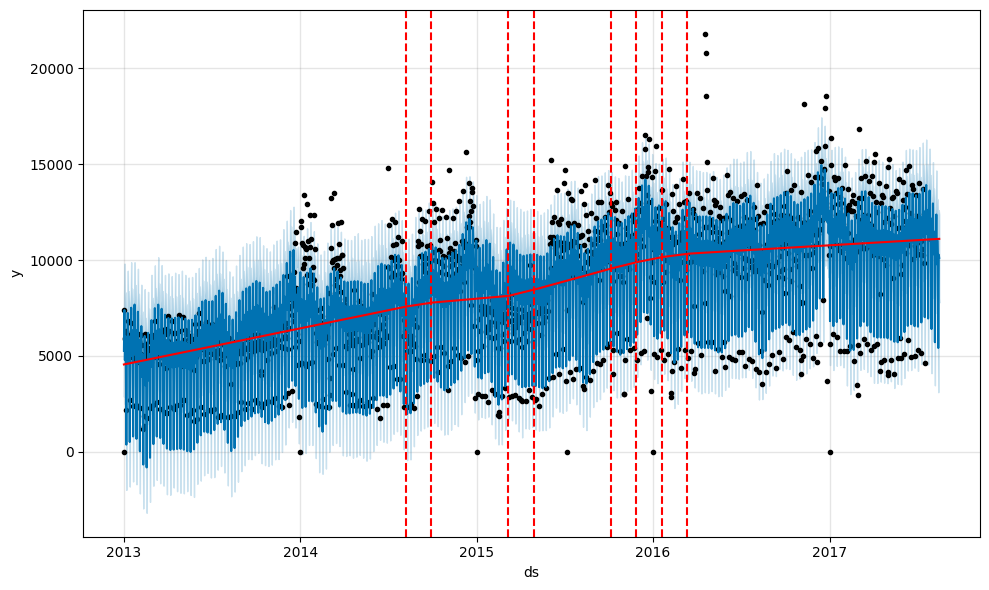

In [102]:
# plot changepoint duting time series data
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [103]:
# merge test set with forecasted values
benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")

# Plot actual and forecasted data
fig = px.line(benchmark_df, x='ds', y=["y", "yhat"], markers=True, title="Prophet forecast")
# Show plot 
fig.show()

In [104]:
# evaluate forecasting using Mean Absolute Percentage Error (MAPE)
evaluate_forecasting_model(
    actual_values=benchmark_df['y'],
    predicted_values=benchmark_df['yhat'],
    round_nbr=3
)

MAE - 1092.469
MSE - 2225490.633
MAPE - 0.146


Prophet forecast using holidays data

In [105]:
# load holidays event
event_df = pd.read_csv("data/holidays_events.csv")
event_df = preprocess_data(event_df)

event_df.head()

,date,type,locale,locale_name,description,transferred,day_of_week
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,Friday
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,Sunday
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,Thursday
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,Saturday
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,Saturday


In [106]:
# preprocess holidays dataframe
holiday_df = event_df.copy()
holiday_df.rename(columns={"date": "ds", "description":"holiday"}, inplace=True)
holiday_df = holiday_df[["ds", "holiday"]]
holiday_df.head()

,ds,holiday
0,2012-03-02,Fundacion de Manta
1,2012-04-01,Provincializacion de Cotopaxi
2,2012-04-12,Fundacion de Cuenca
3,2012-04-14,Cantonizacion de Libertad
4,2012-04-21,Cantonizacion de Riobamba


In [107]:
# init and fit the model
m = Prophet(holidays=holiday_df)
m.fit(train)

# Create Future dates
future_sales = m.make_future_dataframe(periods=30)

# Predict Prices
forecast = m.predict(future_sales)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

17:39:03 - cmdstanpy - INFO - Chain [1] start processing
17:39:04 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,-2757.319298,-4556.787160,-1032.700568
1,2013-01-02,8314.781282,6339.853456,10058.175490
2,2013-01-03,5756.447066,3919.997741,7507.718698
3,2013-01-04,7173.433051,5427.964428,8857.247733
4,2013-01-05,6312.166057,4558.589438,8046.813623


In [108]:
plot_components_plotly(m, forecast, figsize=(1000, 300))

In [109]:
benchmark_df = test.merge(forecast[["ds", "yhat"]], on="ds", how="left")

# Plot actual and forecasted data
fig = px.line(benchmark_df, x='ds', y=["y", "yhat"], markers=True, title="Prophet forecast using event data")
# Show plot
fig.show()

In [110]:
# evaluate forecasting using Mean Absolute Percentage Error (MAPE)
evaluate_forecasting_model(
    actual_values=benchmark_df['y'],
    predicted_values=benchmark_df['yhat'],
    round_nbr=3
)

MAE - 1047.285
MSE - 1629661.767
MAPE - 0.13


### <b><span style='color:#F1C40F'>|</span> Home task</b>

- Choose any store from the initial dataset
- Check the presence of nans and fill them
- Make a forecast for 30, 180, 270, 365 days ahead
- Perform model evaluation

### <b><span style='color:#F1C40F'>|</span> References</b>


- Time Series at Scale [https://peerj.com/preprints/3190.pdf]
- Prophet Documentation [https://facebook.github.io/prophet/docs/quick_start.html#python-api]
- What is Time Series [https://medium.com/@ritusantra/what-is-time-series-and-components-of-time-series-c80b69ad5cb9]